In [1]:
# pylint: skip-file
import os

import advsecurenet.shared.types.configs.attack_configs as AttackConfigs
import click
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import torch
from advsecurenet.attacks import (FGSM, LOTS, PGD, CWAttack, DecisionBoundary,
                                  DeepFool, TargetedFGSM)
from advsecurenet.dataloader import DataLoaderFactory
from advsecurenet.datasets import DatasetFactory
from advsecurenet.evaluation.adversarial_evaluator import AdversarialEvaluator
from advsecurenet.evaluation.evaluators.similarity_evaluator import SimilarityEvaluator
from advsecurenet.evaluation.evaluators.transferability_evaluator import \
    TransferabilityEvaluator
from advsecurenet.models.model_factory import ModelFactory
from advsecurenet.shared.types import DatasetType
from advsecurenet.utils.adversarial_target_generator import \
    AdversarialTargetGenerator
    
from advsecurenet.evaluation.evaluators.perturbation_distance_evaluator import PerturbationDistanceEvaluator
from advsecurenet.utils.model_utils import load_model
from advsecurenet.utils.tester import Tester
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from torchvision import transforms

from advsecurenet.evaluation.evaluators.attack_success_rate_evaluator import AttackSuccessRateEvaluator
from advsecurenet.evaluation.evaluators.perturbation_effectiveness_evaluator import PerturbationEffectivenessEvaluator

from advsecurenet.utils.data import unnormalize_data

In [2]:
# get imagenet dataset
dataset = DatasetFactory.create_dataset(DatasetType.CIFAR10)
train_data = dataset.load_dataset(train=True)
test_data = dataset.load_dataset(train=False)
# get dataloader
train_loader = DataLoaderFactory.create_dataloader(train_data, batch_size=64, shuffle=True)

test_loader = DataLoaderFactory.create_dataloader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
resnet18 = ModelFactory.create_model("resnet18", num_classes=10)
load_model(resnet18, "/resnet18/resnet18_final.pth")

swin_v2_t = ModelFactory.create_model("swin_v2_t", num_classes=10)
swin_v2_t = load_model(swin_v2_t, "/swin_v2_t/swin_v2_t_final.pth")

convnext_tiny = ModelFactory.create_model("convnext_tiny", num_classes=10)
convnext_tiny = load_model(convnext_tiny, "/convnext_tiny/convnext_tiny_final.pth")

densenet121 = ModelFactory.create_model("densenet121", num_classes=10)
densenet121 = load_model(densenet121, "/densenet121/densenet121_final.pth")


In [3]:


resnet18 = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
resnet18 = load_model(resnet18, "/resnet18/resnet18_final.pth")

robust_fgsm = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_fgsm = load_model(robust_fgsm, "fgsm01/fgsm0.1/resnet18/resnet18.pth")

robust_pgd = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_pgd = load_model(robust_pgd, "pgd01/resnet18/resnet18.pth")

robust_lots = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_lots = load_model(robust_lots, "lots_single/resnet18_01/resnet18.pth")

robust_fgsm_pgd = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_fgsm_pgd = load_model(robust_fgsm_pgd, "fgsm_pgd_01/resnet18/resnet18.pth")
 
robust_fgsm_pgd_lots = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_fgsm_pgd_lots = load_model(robust_fgsm_pgd_lots, "fgsm_pgd_lots_03/resnet18_01/resnet18.pth")

robust_res_conv = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_res_conv = load_model(robust_res_conv, "ensemble_models/res_conv/resnet18.pth")

robust_res_conv_swin = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_res_conv_swin = load_model(robust_res_conv_swin, "ensemble_models/res_conv_swin/resnet18.pth")

robust_res_conv_swin_dense = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_res_conv_swin_dense = load_model(robust_res_conv_swin_dense, "ensemble_models/res_conv_swin_dense/resnet18.pth")

robust_all = ModelFactory.create_model("resnet18", num_classes=10, num_input_channels=3, pretrained=False)
robust_all = load_model(robust_all, "ensemble_models/all/resnet18.pth")





In [9]:
def evaluate_models(models, epsilon_values, attack_cls, config, device, mean, std):
    results = []
    for model in tqdm(models, position=0, leave=False, total=len(models), desc="Iterating over models"):
        model_name = model["name"]
        model = model["model"]
        model = model.to(device)
        model_results = []
        #for epsilon in epsilon_values:
        for epsilon in tqdm(epsilon_values, total=len(epsilon_values), desc=f"Model: {model_name} - Evaluating epsilon"):
            config.epsilon = epsilon
            attack = attack_cls(config)
            success_rate = evaluate(model, attack, mean ,std)
            temp = {"model": model_name, "epsilon": config.epsilon, "success_rate": success_rate}
            model_results.append(temp)
        results.append(model_results)
    return results
        
def evaluate(model, attack, mean, std):
    with AdversarialEvaluator(mean=mean, std=std) as evaluator: 
        
        for images, labels in tqdm(test_loader, total=len(test_loader), desc="Iterating over test set"):
        #for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)  
            
            # unnormalize images
            unnormalize_images = unnormalize_data(images, mean, std)
            
            adv_img = attack.attack(model, unnormalize_images, labels)
            
            # normalize adversarial images
            adv_img = transforms.Normalize(mean, std)(adv_img)
            
            evaluator.update(model, images, labels, adv_img)
        #print("classic results " + str(evaluator.get_results()))
        #robust_results_pgd.append()
        return evaluator.get_results()
    

def plot_results(results, title, key, sub_key=None, model_name=None, grid=True):
    plt.figure(figsize=(10, 6))  # Increase the size of the chart

    for model_data in results:
        if model_name is not None and model_data[0]["model"] != model_name:
            continue
        epsilons = [d['epsilon'] for d in model_data]
        if sub_key is None:
            data = [d['success_rate'][key] for d in model_data]
        else:
            data = [d['success_rate'][key][sub_key] for d in model_data]
        plt.plot(epsilons, data, label=model_data[0]["model"])

    plt.xlabel("Epsilon")
    ylabel = key.replace("_", " ")
    plt.ylabel(ylabel)
    plt.title(title)
    # Move the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(grid)
    
    plt.tight_layout()  # Adjust the layout to accommodate the legend
    plt.show()
    
def plot_double_metrics(results, title, key1, key2, sub_key1=None, sub_key2=None, model_name=None, grid=True, show_legend=True):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color1 = 'tab:blue'
    color2 = 'tab:red'

    for model_data in results:
        if model_name is not None and model_data[0]["model"] != model_name:
            continue
        epsilons = [d['epsilon'] for d in model_data]
        if sub_key1 is None:
            data1 = [d['success_rate'][key1] for d in model_data]
        else:
            data1 = [d['success_rate'][key1][sub_key1] for d in model_data]

        if sub_key2 is None:
            data2 = [d['success_rate'][key2] for d in model_data]
        else:
            data2 = [d['success_rate'][key2][sub_key2] for d in model_data]

        ax1.plot(epsilons, data1, label=f"{model_data[0]['model']} - {key1 if sub_key1 is None else sub_key1}", color=color1)
        ax2.plot(epsilons, data2, label=f"{model_data[0]['model']} - {key2 if sub_key2 is None else sub_key2}", linestyle='--', color=color2)

    ax1.set_xlabel('Epsilon')
    
    ax1.set_ylabel(key1.replace("_", " ") if sub_key1 is None else f"{key1} - {sub_key1}", color=color1)
    ax2.set_ylabel(key2.replace("_", " ") if sub_key2 is None else f"{key2} - {sub_key2}", color=color2)
    
    ax1.tick_params(axis='y', labelcolor=color1)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(title)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if show_legend:
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
    plt.grid(grid)
    plt.show()



In [5]:
device = "cuda:1"
epsilon_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
mean = [0.49139968, 0.48215827, 0.44653124]
std = [0.24703233, 0.24348505, 0.26158768]
config = AttackConfigs.FgsmAttackConfig(
    epsilon=epsilon_values[0],
    device=device,
)


In [ ]:

models = [
    {"name": "NO AT", "model":resnet18},
    {"name": "FGSM AT", "model":robust_fgsm},
    {"name": "PGD AT", "model":robust_pgd},
    {"name": "LOTS AT", "model":robust_lots},
    {"name": "FGSM+PGD AT", "model":robust_fgsm_pgd},
    {"name": "FGSM+PGD+LOTS AT", "model":robust_fgsm_pgd_lots},
    {"name": "ResConv AT", "model":robust_res_conv},
    {"name": "ResConv+Swin AT", "model":robust_res_conv_swin},
    {"name": "ResConv+Swin+Dense AT", "model":robust_res_conv_swin_dense},
    {"name": "ALL AT", "model":robust_all},
]
fgsm_results = evaluate_models(models, epsilon_values, FGSM, config, device, mean, std)


In [7]:
# convert to dataframe
df = pd.DataFrame(fgsm_results[0])
df['model'] = 'NO AT'
df2 = pd.DataFrame(fgsm_results[1])
df2['model'] = 'FGSM AT'
df3 = pd.DataFrame(fgsm_results[2])
df3['model'] = 'PGD AT'
df4 = pd.DataFrame(fgsm_results[3])
df4['model'] = 'LOTS AT'
df5 = pd.DataFrame(fgsm_results[4])
df5['model'] = 'FGSM+PGD AT'
df6 = pd.DataFrame(fgsm_results[5])
df6['model'] = 'FGSM+PGD+LOTS AT'
df7 = pd.DataFrame(fgsm_results[6])
df7['model'] = 'ResConv AT'
df8 = pd.DataFrame(fgsm_results[7])
df8['model'] = 'ResConv+Swin AT'
df9 = pd.DataFrame(fgsm_results[8])
df9['model'] = 'ResConv+Swin+Dense AT'
df10 = pd.DataFrame(fgsm_results[9])
df10['model'] = 'ALL AT'

combined = pd.concat([df, df2, df3, df4, df5, df6, df7, df8, df9, df10])
combined.to_csv('fgsm_results.csv', index=False)


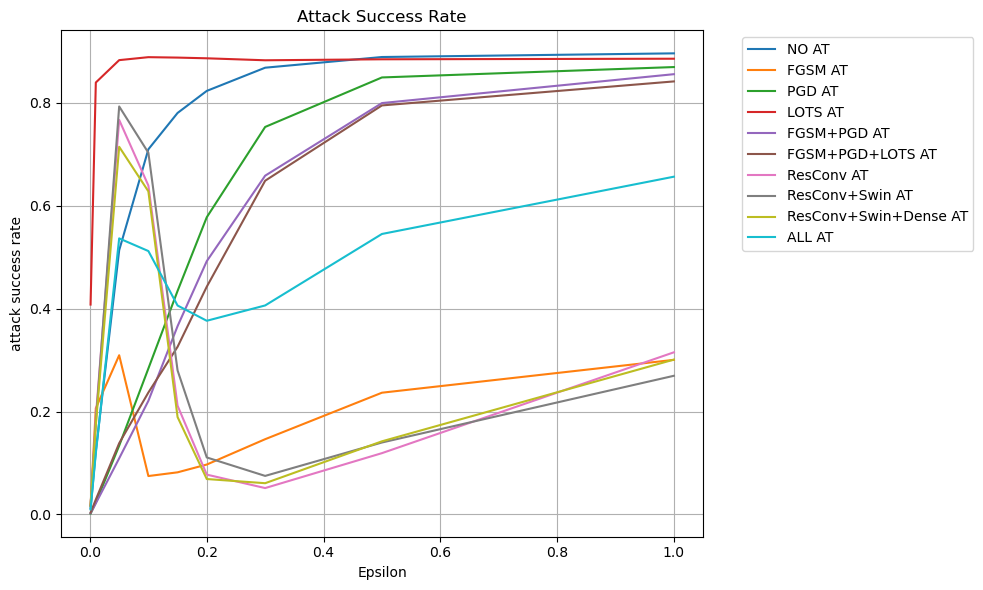

: 

In [18]:
plot_results(fgsm_results, "Attack Success Rate", "attack_success_rate", grid=True)

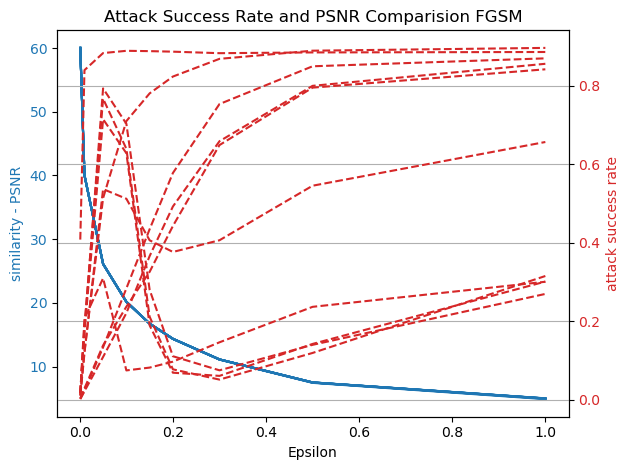

In [15]:
plot_double_metrics(fgsm_results, "Attack Success Rate and PSNR Comparision FGSM", key1="similarity", key2="attack_success_rate", sub_key1="PSNR", show_legend=False)

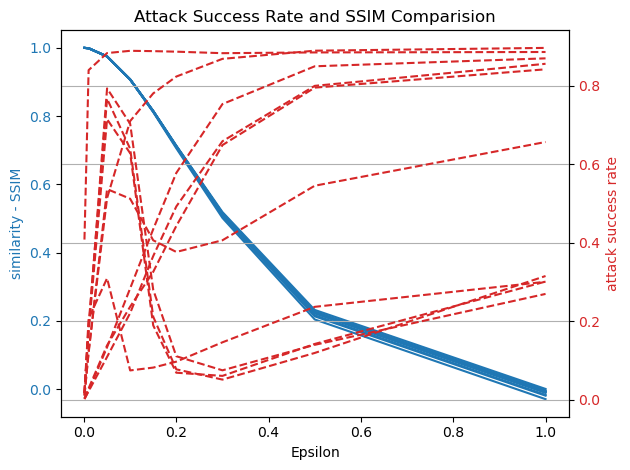

In [13]:
plot_double_metrics(fgsm_results, "Attack Success Rate and SSIM Comparision", key1="similarity", key2="attack_success_rate", sub_key1="SSIM", show_legend=False)

In [12]:
plot_double_metrics(pgd_results, "Attack Success Rate and SSIM Comparision against PGD", key1="similarity", key2="attack_success_rate", sub_key1="SSIM", show_legend=False)

NameError: name 'pgd_results' is not defined

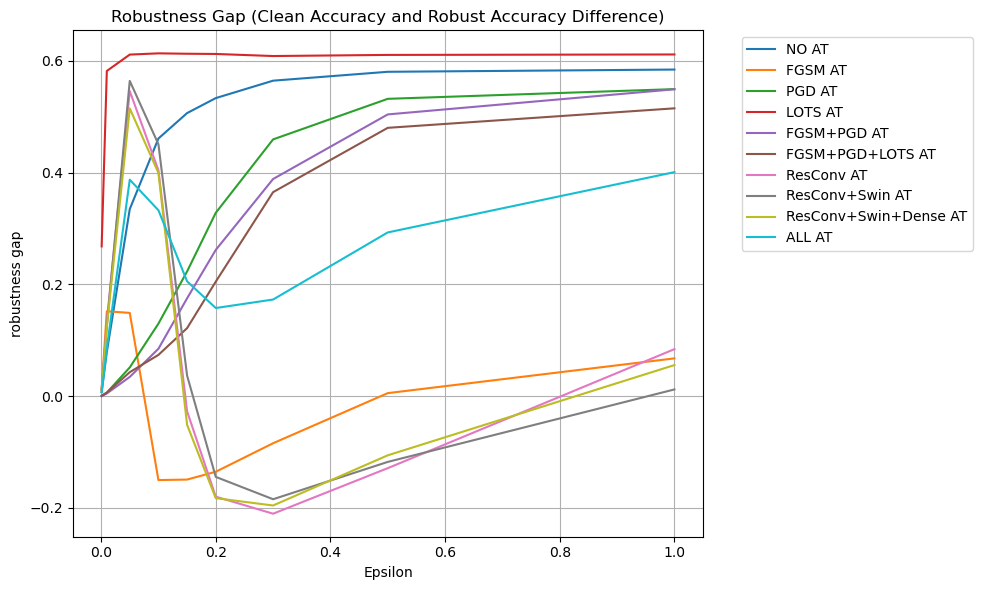

In [11]:
plot_results(fgsm_results, "Robustness Gap (Clean Accuracy and Robust Accuracy Difference)", "robustness_gap", sub_key="robustness_gap", grid=True)

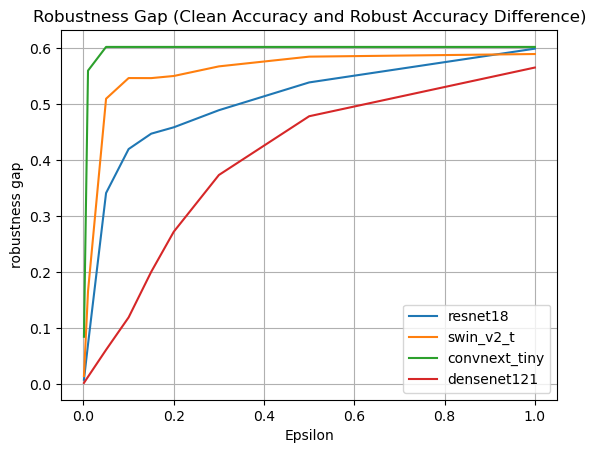

In [53]:
plot_results(pgd_results, "Robustness Gap (Clean Accuracy and Robust Accuracy Difference)", "robustness_gap", sub_key="robustness_gap", grid=True)